TensorFlow version: 2.12.0
Keras version: 2.12.0
Found 40 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Error while initializing VGG16 model: module 'keras.backend' has no attribute 'RandomGenerator'
Error while initializing MobileNetV2 model: module 'keras.backend' has no attribute 'RandomGenerator'
Error while initializing ResNet50 model: module 'keras.backend' has no attribute 'get_graph'
Error while initializing Vision Transformer model: module 'keras.backend' has no attribute 'RandomGenerator'


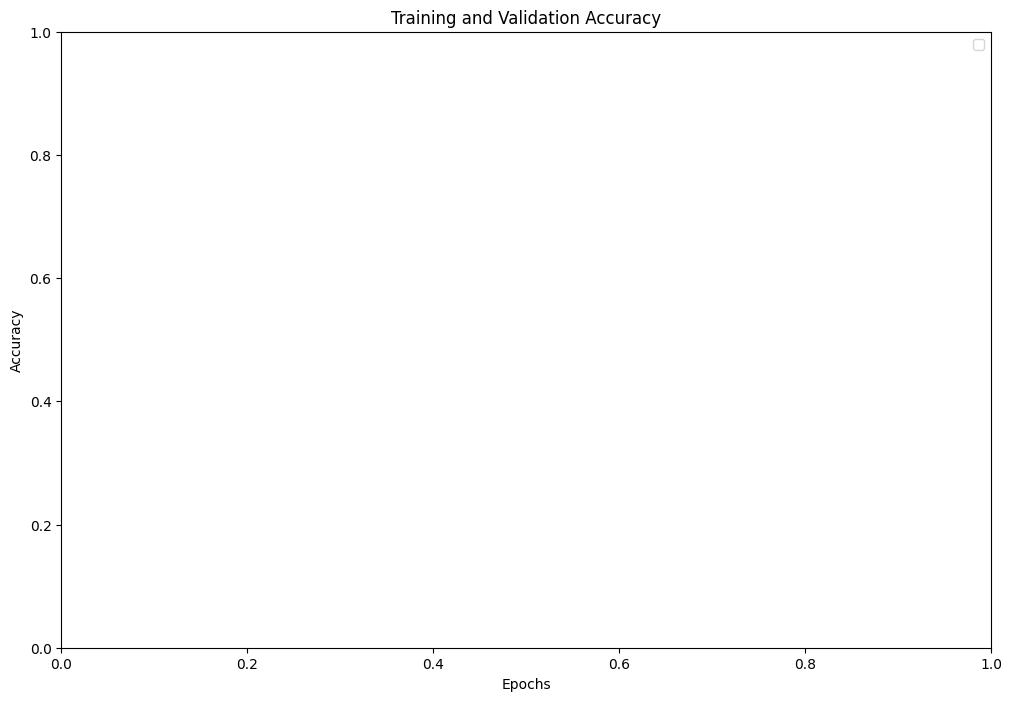

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


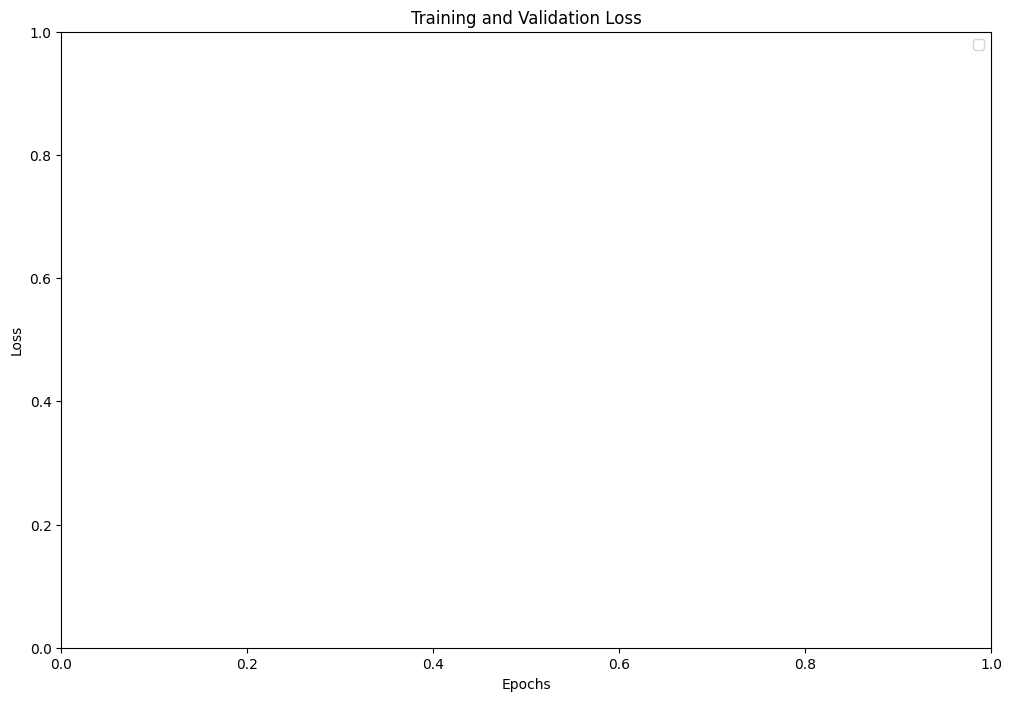

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, MobileNetV2, ResNet50
from vit_keras import vit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Diagnostic: Print TensorFlow and Keras versions
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)

# Define directories
data_dir = r'M:\projects\Major_proj\Fruits_Dataset\cherry fruit'
batch_size = 16  # Reduced batch size to mitigate memory issues
image_size = (224, 224)

# Image Data Generator for preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use 20% of data for validation
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

num_classes = train_generator.num_classes

# Define a function to build the model
def build_model(base_model):
    base_model.trainable = False
    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize models to None
vgg_model = None
mobilenet_model = None
resnet_model = None
vit_model = None

try:
    # VGG16 model
    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    vgg_model = build_model(vgg_base)
except Exception as e:
    print(f"Error while initializing VGG16 model: {e}")

try:
    # MobileNetV2 model
    mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    mobilenet_model = build_model(mobilenet_base)
except Exception as e:
    print(f"Error while initializing MobileNetV2 model: {e}")

try:
    # ResNet50 model
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    resnet_model = build_model(resnet_base)
except Exception as e:
    print(f"Error while initializing ResNet50 model: {e}")

try:
    # Vision Transformer model
    vit_base = vit.vit_b16(
        image_size=224,
        pretrained=True,
        include_top=False,
        pretrained_top=False
    )

    vit_inputs = Input(shape=(224, 224, 3))
    x = vit_base(vit_inputs)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    vit_outputs = Dense(num_classes, activation='softmax')(x)
    vit_model = Model(vit_inputs, vit_outputs)
    vit_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
except Exception as e:
    print(f"Error while initializing Vision Transformer model: {e}")

# Train and evaluate models
models = {
    "VGG16": vgg_model,
    "MobileNetV2": mobilenet_model,
    "ResNet50": resnet_model,
    "VisionTransformer": vit_model
}

history_dict = {}
results = {}

for name, model in models.items():
    if model is not None:  # Check if model initialization was successful
        try:
            print(f"Training {name}...")
            history = model.fit(train_generator, validation_data=validation_generator, epochs=5)  # Reduced epochs for initial testing
            history_dict[name] = history
            results[name] = {
                "accuracy": history.history['accuracy'][-1],
                "val_accuracy": history.history['val_accuracy'][-1],
                "loss": history.history['loss'][-1],
                "val_loss": history.history['val_loss'][-1]
            }
        except Exception as e:
            print(f"Error while training {name}: {e}")

# Plot learning curves
plt.figure(figsize=(12, 8))

for name, history in history_dict.items():
    plt.plot(history.history['accuracy'], label=f'{name} Training Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'{name} Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))

for name, history in history_dict.items():
    plt.plot(history.history['loss'], label=f'{name} Training Loss')
    plt.plot(history.history['val_loss'], label=f'{name} Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Evaluate each model and plot confusion matrix
for name, model in models.items():
    if model is not None:  # Check if model initialization was successful
        try:
            print(f"Evaluating {name}...")
            val_generator = validation_generator
            val_generator.reset()
            y_pred = model.predict(val_generator)
            y_pred_classes = np.argmax(y_pred, axis=1)
            y_true = val_generator.classes
            cm = confusion_matrix(y_true, y_pred_classes)
            print(f"Classification Report for {name}:\n", classification_report(y_true, y_pred_classes, target_names=list(val_generator.class_indices.keys())))
            plot_confusion_matrix(cm, list(val_generator.class_indices.keys()), name)
        except Exception as e:
            print(f"Error while evaluating {name}: {e}")

